In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import f1_score
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.regularizers import l2
from keras import layers
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Bidirectional 
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from tqdm import tqdm
from langua import Predict
import gensim
import time
import re

Using TensorFlow backend.


# Data Preparation & Exploration:

In [2]:
# Load data to pandas df:
df = pd.DataFrame.from_csv('exportESP500k.csv', encoding='utf-8')

In [3]:
#Drop unnecessary columns
df.drop(['tx_id', 'author', 'parent_author', 'timestamp', 'json_metadata', 
         'title', 'title', 'lang'], axis=1, inplace = True, errors='ignore')

In [4]:
df

,body,words_pos_polarity,words_neg_polarity,emoji_pos_polarity,emoji_neg_polarity,word_emoji_pos_pol_diff,word_emoji_neg_pol_diff,label
0,Abit is no spammer,0.000000,-0.200000,0.0,0.0,0.00,0.0,0.0
1,You da man,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
2,B vs S,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
3,URL Como ya sabéis Aniestudio esta en una con...,0.588500,-0.477500,0.0,0.0,0.00,0.0,1.0
4,Hace días que no puedo perder un rato en una g...,0.512667,-0.421667,0.0,0.0,0.00,0.0,1.0
5,El halving e acerca y con el las expectativas ...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
6,Espero pasarla muy bien en este sitio conocer...,0.841500,-0.200000,0.0,0.0,0.00,0.0,1.0
7,info quien desea trabajar desde su casa,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
8,información. Quien quiere trabajar desde casa,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
9,Quiero que alguien me explique como funciona r...,0.321500,0.000000,0.0,0.0,0.00,0.0,0.0


### Label Distribution:

-1 = Negative sentiment,
 0 = No sentiment,
 1 = Positive sentiment

In [5]:
df.label.value_counts()

 0.0    3498
 1.0    1079
-1.0     244
Name: label, dtype: int64

## Data Description:

In [6]:
df.describe()

,words_pos_polarity,words_neg_polarity,emoji_pos_polarity,emoji_neg_polarity,word_emoji_pos_pol_diff,word_emoji_neg_pol_diff,label
count,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000
mean,0.145173,-0.063368,0.038789,-0.001452,0.030847,0.001187,0.173201
std,0.247626,0.152551,0.193111,0.038081,0.162315,0.032406,0.494446
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.990000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000


### Train Test Split

In [136]:
# TRAIN TEST SPLIT DATA:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## TF-IDF Vectorizer:

In [69]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.body)
X_train.shape

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(3615, 4686)

In [70]:
X_test = vectorizer.transform(X_test.body)
X_test.shape

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1206, 4686)

# MACHINE LEARNING ALGORITHMS:

## NAIVE BAYES:

In [24]:
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [25]:
score = gnb.score(X_test.toarray(), y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 70.81260364842454 %


In [26]:
predicted = gnb.predict(X_test.toarray())
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.12      0.42      0.19        69
          0       0.93      0.75      0.83       854
          1       0.67      0.65      0.66       283

avg / total       0.82      0.71      0.75      1206



## LOGISTIC REGRESSION:

In [61]:
model = LogisticRegression(multi_class='ovr')

In [18]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
score = model.score(X_test, y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 85.7379767827529 %


In [20]:
predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       1.00      0.09      0.16        69
          0       0.90      0.95      0.92       854
          1       0.73      0.75      0.74       283

avg / total       0.86      0.86      0.84      1206



## SVM (GAUSIAN KERNEL):

In [21]:
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
score = svclassifier.score(X_test, y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 70.81260364842454 %


In [23]:
predicted = svclassifier.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        69
          0       0.71      1.00      0.83       854
          1       0.00      0.00      0.00       283

avg / total       0.50      0.71      0.59      1206



/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# DEEP LEARNING IMPLEMENTATIONS:

### WORD2VEC & EMBEDDING MATRIX:

In [137]:
# Split text:
split_text = X.body.apply(lambda sent: sent.lower().split())

In [138]:
# Training W2V on posts texts:
w2v = gensim.models.Word2Vec(sentences=split_text, sg=1, min_count=1)

In [139]:
# Check # of unique words:
keys = len(list(w2v.wv.vocab.keys()))
keys

5870

In [140]:
split_text.apply(lambda row: len(row)).value_counts()

2     1991
1     1046
3      308
4      145
6       95
5       90
7       82
9       70
8       58
10      51
11      46
12      46
13      44
16      41
17      41
14      38
15      35
22      29
18      27
19      26
27      26
20      25
21      25
24      24
23      21
35      18
30      17
25      16
32      16
31      13
      ... 
55       7
42       7
53       7
47       6
56       6
50       6
63       5
57       5
43       5
72       5
51       5
75       5
61       4
66       4
46       4
77       3
60       3
64       3
65       3
70       3
74       3
71       3
76       2
69       2
59       2
79       2
68       1
80       1
73       1
67       1
Name: body, Length: 79, dtype: int64

In [141]:
print(X_train)

                                                   body words_pos_polarity  \
4096                                          Ciao Ciao                  0   
4108                                          Ciao Ciao                  0   
1172                                Mas falo quis dizer                  0   
2268                                          Ciao Ciao                  0   
325                                                  Oh                  0   
1051  Creo que se usa una media semanal de todos mod...            0.41375   
2763                                          Ciao Ciao                  0   
3603                                          Ciao Ciao                  0   
3321                                          Ciao Ciao                  0   
1946                                               Ciao                  0   
1196       Te amo Fyrstikken eres lo mejor del mundo <3             0.4625   
620   En el año 2011 Erdogán dijo que ¡Bashar alAssa...         

In [142]:
# TRANSFORMING DATA:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.body)
X_train = tokenizer.texts_to_sequences(X_train.body)
X_test = tokenizer.texts_to_sequences(X_test.body)

In [143]:
# Checking length of sequences
seq = []
for s in range(len(X_train)):
    seq.append(len(X_train[s]))
    #print(s, len(X_train[s]))
print('max:', max(seq), 'min:', min(seq), 'avg:', sum(seq)/len(seq))

max: 96 min: 1 avg: 7.353803596127247


In [144]:
X_train = pad_sequences(X_train, maxlen=90)
X_test = pad_sequences(X_test, maxlen=90)

In [145]:
X_train

array([[   0,    0,    0, ...,    0,    1,    1],
       [   0,    0,    0, ...,    0,    1,    1],
       [   0,    0,    0, ..., 3954, 3955, 3956],
       ...,
       [   0,    0,    0, ...,    6,  233,  291],
       [   0,    0,    0, ...,    0,    1,    1],
       [   0,    0,    0, ...,    0,  758, 3594]], dtype=int32)

In [146]:
# Embedding Matrix:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
vec = []
for word, i in tokenizer.word_index.items():
    if word in w2v.wv.vocab:
        embedding_vector = w2v.wv.get_vector(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        vec.append(word)

In [147]:
embedding_matrix.shape

(5692, 100)

In [148]:
# y as categorical
y = to_categorical(y_train.as_matrix()+1)

In [149]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

## 1D CNN:

In [28]:
# CNN Model
model = Sequential()       
model.add(layers.Embedding(keys+1, 128, input_length=90))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [29]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 128)           751488    
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 86, 8)             5128      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 8)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 43, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 8)             136       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 8)             0         
__________

In [30]:
%%time
# Fit Model
history = model.fit([X_train], y, verbose=1, epochs=60, 
                    batch_size=128, validation_split=0.2)

Train on 2892 samples, validate on 723 samples
Epoch 1/60
2892/2892 [==============================] - 2s 709us/step - loss: 0.9765 - acc: 0.5595 - val_loss: 0.8709 - val_acc: 0.7303
Epoch 2/60
2892/2892 [==============================] - 1s 436us/step - loss: 0.8974 - acc: 0.6511 - val_loss: 0.8853 - val_acc: 0.7303
Epoch 3/60
2892/2892 [==============================] - 1s 442us/step - loss: 0.8523 - acc: 0.6629 - val_loss: 0.8650 - val_acc: 0.7303
Epoch 4/60
2892/2892 [==============================] - 1s 487us/step - loss: 0.8562 - acc: 0.6625 - val_loss: 0.8228 - val_acc: 0.7303
Epoch 5/60
2892/2892 [==============================] - 1s 445us/step - loss: 0.8173 - acc: 0.7109 - val_loss: 0.7833 - val_acc: 0.7303
Epoch 6/60
2892/2892 [==============================] - 1s 398us/step - loss: 0.8104 - acc: 0.7286 - val_loss: 0.7547 - val_acc: 0.7303
Epoch 7/60
2892/2892 [==============================] - 1s 382us/step - loss: 0.7704 - acc: 0.7268 - val_loss: 0.6711 - val_acc: 0.7303
E

In [31]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

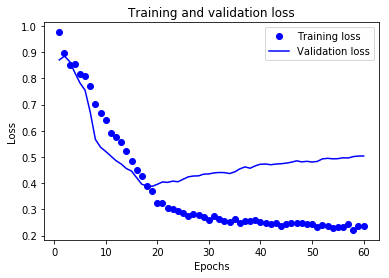

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

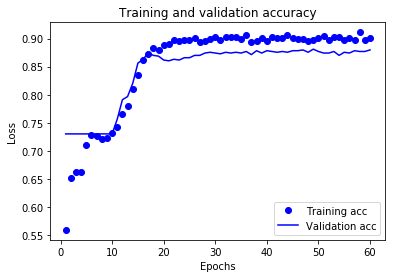

In [33]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 91.11341627966483 Epoch: 57 Best Validation Accuracy: 88.1051173760848 Epoch: 48
Lowest Training Loss value: 22.153809233819796 Epoch: 57 Lowest Validation Loss: 38.799144811979794 Epoch: 18


### 1D CNN BEST MODEL TEST RESULTS:

In [35]:
# Some memory clean-up
K.clear_session()

In [36]:
model = Sequential()       
model.add(layers.Embedding(keys+1, 128, input_length=90))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [38]:
model.fit([X_train], y, verbose=0, epochs=48, 
          batch_size=128)

In [39]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

1206/1206 [==============================] - 0s 218us/step


[0.6469550292883346, 0.8383084579091364]

In [40]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [41]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.6224848933454865
F1 Score (Micro): 0.8374792703150912


In [42]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.17      0.32      0.22        38
          0       0.91      0.93      0.92       834
          1       0.79      0.67      0.73       334

avg / total       0.85      0.84      0.84      1206



## LSTM:

In [60]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 90, 128)           751488    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 90, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 883,459
Trainable params: 883,459
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 2892 samples, validate on 723 samples
Epoch 1/50
2892/2892 [==============================] - 15s 5ms/step - loss: 0.5822 - acc: 0.7552 - val_loss: 0.4634 - val_acc: 0.8174
Epoch 2/50
2892/2892 [==============================] - 14s 5ms/step - loss: 0.3786 - acc: 0.8520 - val_loss: 0.3778 - val_acc: 0.8409
Epoch 3/50
2892/2892 [==============================] - 14s 5ms/step - loss: 0.2763 - acc: 0.9018 - val_loss: 0.3633 - val_acc: 0.8520
Epoch 4/50
2892/2892 [==============================] - 13s 5ms/step - loss: 0.2054 - acc: 0.9250 - val_loss: 0.3836 - val_acc: 0.8548
Epoch 5/50
2892/2892 [==============================] - 13s 4ms/step - loss: 0.1541 - acc: 0.9443 - val_loss: 0.3971 - val_acc: 0.8451
Epoch 6/50
2892/2892 [==============================] - 13s 4ms/step - loss: 0.1201 - acc: 0.9640 - val_loss: 0.3949 - val_acc: 0.8506
Epoch 7/50
2892/2892 [==============================] - 12s 4ms/step - loss: 0.0854 - acc: 0.9744 - val_loss: 0.4819 - val_acc: 0.8326
Epoch 8/

In [62]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

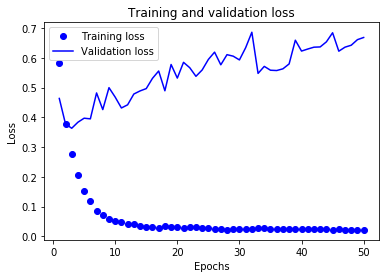

In [63]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

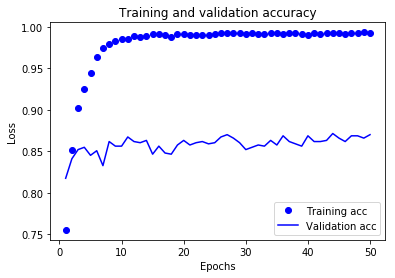

In [64]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [65]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.34301521438451 Epoch: 48 Best Validation Accuracy: 87.13692953477756 Epoch: 43
Lowest Training Loss value: 2.177151137374259 Epoch: 48 Lowest Validation Loss: 36.328719488318036 Epoch: 2


### LSTM BEST MODEL TEST RESULTS:

In [74]:
# Some memory clean-up
K.clear_session()

In [67]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [68]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [69]:
model.fit([X_train], y, verbose=0, epochs=43, 
          batch_size=32)

In [70]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

1206/1206 [==============================] - 1s 1ms/step


[0.7793047416269483, 0.8673300167814416]

In [71]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [72]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.7295032769490044
F1 Score (Micro): 0.8665008291873963


In [73]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.45      0.55      0.50        56
          0       0.94      0.91      0.92       878
          1       0.75      0.78      0.77       272

avg / total       0.87      0.87      0.87      1206



## GRU RNN:

In [92]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(GRU(128, dropout=0.2, return_sequences=True)) 
model.add(GRU(128, dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 128)           751488    
_________________________________________________________________
gru_1 (GRU)                  (None, 90, 128)           98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 949,251
Trainable params: 949,251
Non-trainable params: 0
_________________________________________________________________


In [93]:
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 2892 samples, validate on 723 samples
Epoch 1/50
2892/2892 [==============================] - 18s 6ms/step - loss: 0.5013 - acc: 0.7825 - val_loss: 0.3748 - val_acc: 0.8423
Epoch 2/50
2892/2892 [==============================] - 17s 6ms/step - loss: 0.2752 - acc: 0.8983 - val_loss: 0.3704 - val_acc: 0.8603
Epoch 3/50
2892/2892 [==============================] - 16s 6ms/step - loss: 0.1496 - acc: 0.9485 - val_loss: 0.4136 - val_acc: 0.8672
Epoch 4/50
2892/2892 [==============================] - 17s 6ms/step - loss: 0.0795 - acc: 0.9772 - val_loss: 0.4377 - val_acc: 0.8769
Epoch 5/50
2892/2892 [==============================] - 18s 6ms/step - loss: 0.0497 - acc: 0.9837 - val_loss: 0.4675 - val_acc: 0.8700
Epoch 6/50
2892/2892 [==============================] - 20s 7ms/step - loss: 0.0469 - acc: 0.9876 - val_loss: 0.4298 - val_acc: 0.8769
Epoch 7/50
2892/2892 [==============================] - 18s 6ms/step - loss: 0.0345 - acc: 0.9900 - val_loss: 0.5054 - val_acc: 0.8631
Epoch 8/

In [94]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

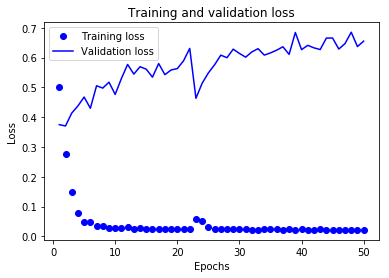

In [95]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

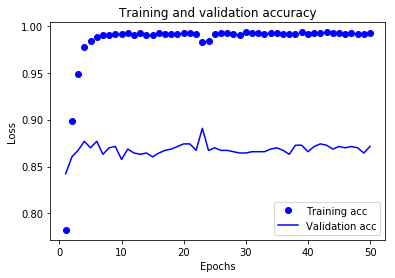

In [96]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [97]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.30843706777317 Epoch: 29 Best Validation Accuracy: 89.0733056873042 Epoch: 22
Lowest Training Loss value: 2.142882282136557 Epoch: 38 Lowest Validation Loss: 37.04314381090272 Epoch: 1


### GRU RNN BEST MODEL TEST RESULTS:

In [106]:
# Some memory clean-up
K.clear_session()

In [99]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(GRU(128, dropout=0.2, return_sequences=True)) 
model.add(GRU(128, dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [100]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [101]:
%%time
model.fit([X_train], y, verbose=0, epochs=22, 
          batch_size=32)

CPU times: user 22min 45s, sys: 5min 6s, total: 27min 52s
Wall time: 6min 29s


In [102]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

1206/1206 [==============================] - 2s 1ms/step


[0.5169531807772951, 0.8731343285559027]

In [103]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [104]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.7142184847465757
F1 Score (Micro): 0.8723051409618574


In [105]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.39      0.47      0.43        57
          0       0.95      0.91      0.93       895
          1       0.74      0.83      0.78       254

avg / total       0.88      0.87      0.88      1206



## BiLSTM:

In [150]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 128)           751488    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 850,691
Trainable params: 850,691
Non-trainable params: 0
_________________________________________________________________


In [151]:
%%time
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 2892 samples, validate on 723 samples
Epoch 1/50
2892/2892 [==============================] - 12s 4ms/step - loss: 0.5785 - acc: 0.7663 - val_loss: 0.4189 - val_acc: 0.8050
Epoch 2/50
2892/2892 [==============================] - 10s 3ms/step - loss: 0.3332 - acc: 0.8817 - val_loss: 0.3551 - val_acc: 0.8658
Epoch 3/50
2892/2892 [==============================] - 10s 4ms/step - loss: 0.2077 - acc: 0.9243 - val_loss: 0.3615 - val_acc: 0.8631
Epoch 4/50
2892/2892 [==============================] - 10s 3ms/step - loss: 0.1347 - acc: 0.9540 - val_loss: 0.4167 - val_acc: 0.8492
Epoch 5/50
2892/2892 [==============================] - 10s 4ms/step - loss: 0.0918 - acc: 0.9692 - val_loss: 0.4115 - val_acc: 0.8672
Epoch 6/50
2892/2892 [==============================] - 10s 4ms/step - loss: 0.0551 - acc: 0.9865 - val_loss: 0.5688 - val_acc: 0.8575
Epoch 7/50
2892/2892 [==============================] - 10s 4ms/step - loss: 0.0460 - acc: 0.9872 - val_loss: 0.4907 - val_acc: 0.8617
Epoch 8/

In [152]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

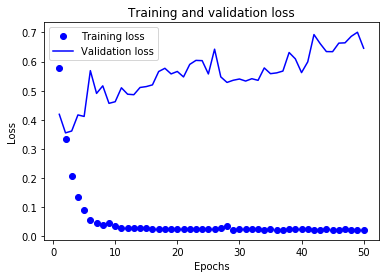

In [153]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

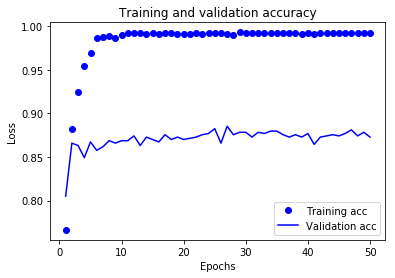

In [154]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [155]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.30843706777317 Epoch: 28 Best Validation Accuracy: 88.52005539923124 Epoch: 26
Lowest Training Loss value: 2.171425742256928 Epoch: 48 Lowest Validation Loss: 35.50742372025428 Epoch: 1


### BiLSTM BEST MODEL TEST RESULTS:

In [156]:
# Some memory clean-up
K.clear_session()

In [157]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [142]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [158]:
%%time
model.fit([X_train], y, verbose=0, epochs=26, 
          batch_size=32)

CPU times: user 20min 54s, sys: 3min 42s, total: 24min 37s
Wall time: 4min 57s


In [159]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

1206/1206 [==============================] - 1s 852us/step


[0.6096071033533137, 0.8747927033486058]

In [160]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [161]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.7462613242739143
F1 Score (Micro): 0.8739635157545605


In [162]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.49      0.58      0.53        59
          0       0.94      0.92      0.93       874
          1       0.76      0.79      0.78       273

avg / total       0.88      0.87      0.88      1206

